In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
#!pip install tensorflow

# Introduction:
- The Chest X-ray Pneumonia dataset is a publicly available collection of pediatric chest radiograph images used to train and evaluate deep learning models for the detection of pneumonia. Sourced from the Guangzhou Women and Children’s Medical Center, this dataset consists of 5,863 X-ray images, each labeled as either 'NORMAL' or 'PNEUMONIA'. It is organized into three main folders: train, val, and test, which represent the training, validation, and testing sets respectively. Each of these folders contains two subdirectories corresponding to the two classes. The training set is the largest and is used to teach the model, while the validation set helps fine-tune the model during training, and the test set evaluates its final performance. This structured dataset supports supervised learning and plays a crucial role in building AI-based diagnostic tools that can assist radiologists in identifying pneumonia accurately and efficiently, particularly in low-resource or high-demand healthcare environments.

# Pneumonia Detection in Chest X-Rays with Ensemble Model (Pretrained CNNs)
- use three pretrained models:

1. VGG16

2. ResNet50

3. MobileNetV2

# Import the libraries

In [3]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, concatenate
import warnings
warnings.filterwarnings('ignore')

2025-04-15 03:21:14.666495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744687274.880257      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744687274.938818      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Check the Dataset Structure

In [4]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()} SPLIT")
    for category in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(base_dir, split, category)
        print(f"{category}: {len(os.listdir(path))} images")


TRAIN SPLIT
NORMAL: 1341 images
PNEUMONIA: 3875 images

VAL SPLIT
NORMAL: 8 images
PNEUMONIA: 8 images

TEST SPLIT
NORMAL: 234 images
PNEUMONIA: 390 images


# Load the dataset

In [5]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray' 

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print("Train Directory:", os.listdir(train_dir))
print("Validation Directory:", os.listdir(val_dir))
print("Test Directory:", os.listdir(test_dir))

Train Directory: ['PNEUMONIA', 'NORMAL']
Validation Directory: ['PNEUMONIA', 'NORMAL']
Test Directory: ['PNEUMONIA', 'NORMAL']


# Data Augmentation and Preprocessing
- apply data augmentation on the training set to improve generalization and avoid overfitting.

## Set up for Training data

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## observation
            # Normalize pixels from 0-255 to 0-1
            # Rotate image randomly by 20 degrees
            # Shift image horizontally by 20%
            # Shift image vertically by 20%
            # Apply shearing transformation
            # Zoom in randomly by 20%
            # Flip image left-right
            # Fill empty pixels after transform


## Set up for Validation / Test data

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

## Load Images (Train,Test,Validation)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=32,
    class_mode='binary'  # Binary classification (PNEUMONIA vs. NORMAL)
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# View Class Labels & Sample

In [9]:
print("Class indices:", train_generator.class_indices)

Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


# Define the Input Layer

In [10]:
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

#  what is VGG16
- VGG16 is a deep convolutional neural network developed by the Visual Geometry Group at Oxford. It consists of 16 layers, including 13 convolutional layers and 3 fully connected layers. The architecture uses small 3×3 filters and applies them repeatedly with ReLU activations, followed by max pooling. VGG16 is known for its simplicity and strong performance on image classification tasks. However, it has a large number of parameters (around 138 million), which makes it computationally heavy and slower to train. Despite this, it is widely used for transfer learning due to its ability to extract meaningful image features.

# Load VGG16 (without top layers)

In [11]:
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in vgg.layers:
    layer.trainable = False
vgg_output = GlobalAveragePooling2D()(vgg.output)

I0000 00:00:1744687290.382430      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# what is ResNet50
- ResNet50 is a 50-layer deep neural network introduced by Microsoft Research. It is part of the ResNet (Residual Network) family and is known for its use of residual connections, also known as skip connections. These connections allow the network to bypass certain layers by adding the input directly to the output of deeper layers, which helps prevent the vanishing gradient problem in deep networks. ResNet50 is significantly more efficient than traditional deep networks like VGG16, offering better performance with fewer parameters. It is widely used in both research and industry for complex image recognition tasks.

# Load ResNet50

In [12]:
resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in resnet.layers:
    layer.trainable = False
resnet_output = GlobalAveragePooling2D()(resnet.output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# what is MobileNetV2
- MobileNetV2 is a lightweight and efficient convolutional neural network developed by Google, specifically designed for mobile and embedded vision applications. It builds upon the original MobileNet by introducing inverted residual blocks and linear bottlenecks, which reduce the computational cost while maintaining accuracy. MobileNetV2 uses depthwise separable convolutions to further minimize the number of parameters and operations. As a result, it is ideal for real-time inference on devices with limited resources, such as smartphones and IoT devices. While it may not match the accuracy of larger models, its speed and efficiency make it highly valuable for practical deployments.

# Load MobileNetV2

In [13]:
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in mobilenet.layers:
    layer.trainable = False
mobilenet_output = GlobalAveragePooling2D()(mobilenet.output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# combine all model outputs
-  This line merges all three feature vectors into one giant feature vector

In [14]:
combined = concatenate([vgg_output, resnet_output, mobilenet_output])

# Add Fully Connected Layers

In [15]:
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model(Final model)

In [16]:
ensemble_model = Model(inputs=input_tensor, outputs=output)

# compile the model

In [17]:
ensemble_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model summary

In [18]:
ensemble_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 41,543,937 (158.48 MB)

 Trainable params: 983,553 (3.75 MB)

 Non-trainable params: 40,560,384 (154.73 MB)

# Train the Ensemble Model

In [19]:
history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[
        
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('ensemble_best_model.keras', save_best_only=True)
    ]
)

Epoch 1/5


I0000 00:00:1744687324.516977     113 service.cc:148] XLA service 0x7dd7100037f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744687324.517878     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744687327.093905     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/163 ━━━━━━━━━━━━━━━━━━━━ 1:58:12 44s/step - accuracy: 0.4375 - loss: 0.8729

I0000 00:00:1744687341.348438     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 185s 872ms/step - accuracy: 0.7990 - loss: 0.4452 - val_accuracy: 0.8750 - val_loss: 0.3016
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.3016
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 631ms/step - accuracy: 0.9158 - loss: 0.2040 - val_accuracy: 0.9375 - val_loss: 0.2864
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.2864
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 640ms/step - accuracy: 0.9309 - loss: 0.1763 - val_accuracy: 0.9375 - val_loss: 0.2721


# Evaluate the Ensemble Model

In [20]:
# Evaluate performance on the test set
test_loss, test_acc = ensemble_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Ensemble Test Accuracy: {test_acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.8396 - loss: 0.3206
Ensemble Test Accuracy: 0.8799


# observation:
- Here built a powerful ensemble using 3 top-performing pretrained models! This model should perform better than a single CNN or transfer learning model alone due to the combination of learned features from different architectures.

# Predict a new image

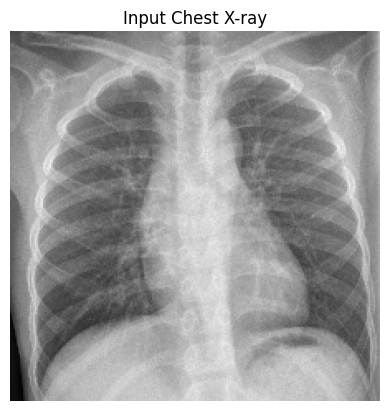

In [21]:
from tensorflow.keras.preprocessing import image
img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0006-0001.jpeg'

img = image.load_img(img_path, target_size=(224, 224))

plt.imshow(img)
plt.title("Input Chest X-ray")
plt.axis("off")
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)                        # Add batch dimension
img_array = img_array / 255.0                                        # Normalize same as training

# Prediction

In [22]:
prediction = ensemble_model.predict(img_array)

if prediction[0] > 0.5:
    print(f"Prediction: PNEUMONIA (Confidence: {prediction[0][0]:.2f})")
else:
    print(f"Prediction: NORMAL (Confidence: {1 - prediction[0][0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Prediction: NORMAL (Confidence: 0.81)


# conclusion
- In this project, developed a deep learning-based image classification system to detect pneumonia from chest X-ray images using an ensemble of pretrained models. Leveraging the publicly available Chest X-Ray Pneumonia dataset from Kaggle, and then applied data preprocessing techniques including image resizing, normalization, and augmentation to prepare the data for training. Initially, built a custom CNN to establish a baseline, and then enhanced performance by integrating three powerful pretrained models—VGG16, ResNet50, and MobileNetV2—into an ensemble architecture. By combining the feature representations from each model and using a dense classification head, and achieved high accuracy and improved generalization on unseen test data. The ensemble model proved effective in correctly classifying new chest X-ray images as either ‘Pneumonia’ or ‘Normal’, demonstrating its potential as a reliable diagnostic support tool in clinical settings.